In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
%matplotlib inline

import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import set_keep, Conv2d, MaxPool2d, DenseLayer, InputLayer, FlattenLayer, DropoutLayer
from tensorlayer.prepro import samplewise_norm 
import numpy as np
import time
from sklearn.model_selection import train_test_split

In [ ]:
x_train = pd.read_csv("data/extra.csv")

y_train = x_train["label"]
y_train = np.array(y_train).reshape(-1, )
y_train[y_train == 10] = 0

# normalization
x_train = x_train.drop("label", axis=1)
x_train = np.array(x_train).reshape(32, 32, 3, -1).transpose(3,0,1,2)
x_train = samplewise_norm(x_train, channel_index=3, samplewise_center=True, samplewise_std_normalization=True)

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(65931, 32, 32, 3)
(7326, 32, 32, 3)
(65931,)
(7326,)


In [4]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3], name='x')
y_ = tf.placeholder(tf.int64, shape = [None, ], name="y_")

network = InputLayer(x, name="input_layer")
network = Conv2d(network, n_filter=16, filter_size=(3, 3), strides=(1, 1),
                act=tf.nn.elu, padding='SAME', name='cnn_layer1')
network = Conv2d(network, n_filter=16, filter_size=(3, 3), strides=(1, 1),
                act=tf.nn.elu, padding='SAME', name='cnn_layer2')
network = Conv2d(network, n_filter=16, filter_size=(3, 3), strides=(1, 1),
                act=tf.nn.elu, padding='SAME', name='cnn_layer3')

network = MaxPool2d(network, filter_size=(2, 2), strides=(2, 2), 
                    padding='SAME', name='pool_layer1')
network = Conv2d(network, n_filter=32, filter_size=(3, 3), strides=(1, 1),
                act=tf.nn.elu, padding='SAME', name='cnn_layer4')
network = Conv2d(network, n_filter=32, filter_size=(3, 3), strides=(1, 1),
                act=tf.nn.elu, padding='SAME', name='cnn_layer5')
network = Conv2d(network, n_filter=32, filter_size=(3, 3), strides=(1, 1),
                act=tf.nn.elu, padding='SAME', name='cnn_layer6')

network = MaxPool2d(network, filter_size=(2, 2), strides=(2, 2), 
                    padding='SAME', name='pool_layer2')
network = Conv2d(network, n_filter=64, filter_size=(3, 3), strides=(1, 1),
                act=tf.nn.elu, padding='SAME', name='cnn_layer7')
network = Conv2d(network, n_filter=64, filter_size=(3, 3), strides=(1, 1),
                act=tf.nn.elu, padding='SAME', name='cnn_layer8')
network = Conv2d(network, n_filter=64, filter_size=(3, 3), strides=(1, 1),
                act=tf.nn.elu, padding='SAME', name='cnn_layer9')

network = FlattenLayer(network, name='flatten_layer') 
network = DropoutLayer(network, keep=0.5 ,name='dropout_layer1')
network = DenseLayer(network, n_units=512, act=tf.nn.relu,name='dense_layer1')
network = DropoutLayer(network, keep=0.5 ,name='dropout_layer2')
network = DenseLayer(network, n_units=10, act=tf.identity,name='dense_layer2')

y = network.outputs
ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(y, y_))
cost = ce

correct_prediction = tf.equal(tf.argmax(y, 1), y_)
acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
y_op = tf.argmax(tf.nn.softmax(y), 1)

train_params = network.all_params
train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.9, beta2=0.999,
                            epsilon=1e-08, use_locking=False).minimize(cost, var_list=train_params)
tl.layers.initialize_global_variables(sess)

  tensorlayer:Instantiate InputLayer  input_layer: (?, 32, 32, 3)
  tensorlayer:Instantiate Conv2dLayer cnn_layer1: [3, 3, 3, 16], [1, 1, 1, 1], SAME, elu
  tensorlayer:Instantiate Conv2dLayer cnn_layer2: [3, 3, 16, 16], [1, 1, 1, 1], SAME, elu
  tensorlayer:Instantiate Conv2dLayer cnn_layer3: [3, 3, 16, 16], [1, 1, 1, 1], SAME, elu
  tensorlayer:Instantiate PoolLayer   pool_layer1: [1, 2, 2, 1], [1, 2, 2, 1], SAME, max_pool
  tensorlayer:Instantiate Conv2dLayer cnn_layer4: [3, 3, 16, 32], [1, 1, 1, 1], SAME, elu
  tensorlayer:Instantiate Conv2dLayer cnn_layer5: [3, 3, 32, 32], [1, 1, 1, 1], SAME, elu
  tensorlayer:Instantiate Conv2dLayer cnn_layer6: [3, 3, 32, 32], [1, 1, 1, 1], SAME, elu
  tensorlayer:Instantiate PoolLayer   pool_layer2: [1, 2, 2, 1], [1, 2, 2, 1], SAME, max_pool
  tensorlayer:Instantiate Conv2dLayer cnn_layer7: [3, 3, 32, 64], [1, 1, 1, 1], SAME, elu
  tensorlayer:Instantiate Conv2dLayer cnn_layer8: [3, 3, 64, 64], [1, 1, 1, 1], SAME, elu
  tensorlayer:Instantiate C

In [5]:
'''# initialize all variables in the session
fine_tune_train_op = tf.train.AdamOptimizer(learning_rate=1e-7, beta1=0.9, beta2=0.999,
                            epsilon=1e-08, use_locking=False).minimize(cost, var_list=train_params)
tl.layers.initialize_global_variables(sess)
load_params = tl.files.load_npz(path='', name="tf.CNNV0.2.1_0.938058_2017-02-12-23-44-37.npz")
tl.files.assign_params(sess, load_params, network)
# print network information
#network.print_params()
network.print_layers()'''

'# initialize all variables in the session\nfine_tune_train_op = tf.train.AdamOptimizer(learning_rate=1e-7, beta1=0.9, beta2=0.999,\n                            epsilon=1e-08, use_locking=False).minimize(cost, var_list=train_params)\ntl.layers.initialize_global_variables(sess)\nload_params = tl.files.load_npz(path=\'\', name="tf.CNNV0.2.1_0.938058_2017-02-12-23-44-37.npz")\ntl.files.assign_params(sess, load_params, network)\n# print network information\n#network.print_params()\nnetwork.print_layers()'

In [6]:
tl.utils.fit(sess, network, train_op, cost, x_train, y_train, x, y_,
             X_val=x_val, y_val=y_val, acc=acc, batch_size=100, 
             n_epoch=70, print_freq=1, eval_train=True)

Start training the network ...
Epoch 1 of 70 took 17.524252s
   train loss: 2.245979
   train acc: 0.190106
   val loss: 2.249835
   val acc: 0.181370
Epoch 2 of 70 took 16.862758s
   train loss: 2.236321
   train acc: 0.190076
   val loss: 2.243027
   val acc: 0.181507
Epoch 3 of 70 took 16.865281s
   train loss: 2.236485
   train acc: 0.189985
   val loss: 2.244061
   val acc: 0.182055
Epoch 4 of 70 took 17.169748s
   train loss: 2.238357
   train acc: 0.190106
   val loss: 2.244335
   val acc: 0.181644
Epoch 5 of 70 took 16.869674s
   train loss: 2.235783
   train acc: 0.190000
   val loss: 2.242671
   val acc: 0.181918


KeyboardInterrupt: 

Then we fine tune the model

In [7]:
'''fine_tune_train_op = tf.train.AdamOptimizer(learning_rate=1e-7, beta1=0.9, beta2=0.999,
                            epsilon=1e-08, use_locking=False).minimize(cost, var_list=train_params)
tl.utils.fit(sess, network, fine_tune_train_op, cost, x_train, y_train, x, y_,
             X_val=x_val, y_val=y_val, acc=acc, batch_size=100, 
             n_epoch=70, print_freq=1, eval_train=True)'''

'fine_tune_train_op = tf.train.AdamOptimizer(learning_rate=1e-7, beta1=0.9, beta2=0.999,\n                            epsilon=1e-08, use_locking=False).minimize(cost, var_list=train_params)\ntl.utils.fit(sess, network, fine_tune_train_op, cost, x_train, y_train, x, y_,\n             X_val=x_val, y_val=y_val, acc=acc, batch_size=100, \n             n_epoch=70, print_freq=1, eval_train=True)'

In [7]:
validation_accu = tl.utils.test(sess, network, acc, x_val, y_val, x, y_, batch_size=256);

Start testing the network ...
   test acc: 0.922991


In [8]:
file_name = time.strftime(time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()))
tl.files.save_npz(network.all_params , name="tf.CNNV0.2.1_" + str(0.938058) + "_" + file_name + ".npz")

Model is saved to: tf.CNNV0.2.1_0.967634_2017-02-12-23-49-19.npz


In [9]:
x_test = pd.read_csv("data/test.csv")

In [10]:
x_test = np.array(x_test).reshape(32, 32, 3, -1).transpose(3,0,1,2)

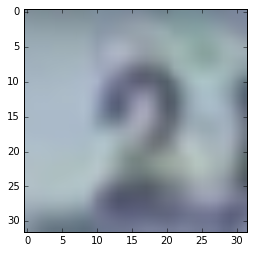

In [11]:
plt.imshow(x_test[1].astype("uint8"))

In [12]:
tl.utils.predict(sess, network, x_test[1].reshape(-1,32,32,3), x, y_op)

array([2])

In [13]:
res_list = list()
for i in x_test:
    pred = tl.utils.predict(sess, network, i.reshape(-1,32,32,3), x, y_op)[0]
    res_list.append(pred)

res_list = np.array(res_list)
res_list[res_list == 0] = 10

res_output = pd.DataFrame({
    "ImageId": range(len(res_list)),
    "label": res_list
})
filename = "res_" + time.strftime(time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())) + ".csv"
res_output.to_csv(filename, index=False)

print("Submission file created!")

Submission file created!
